In [1]:
import dagshub
import mlflow
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Load Dataset

In [2]:
pwd

'D:\\reddit-sentiment-analysis\\experimentations'

In [3]:
# load the data
PATH = r"../data/reddit_cleaned_data.csv"
df = pd.read_csv(PATH)

df.head()

,comment,sentiment,stop_words_count,neg_stop_words_count,word_count,named_sentiment,sentence_length,response,nouns,verbs,adjectives
0,family mormon never tried explain still stare ...,1,13,0,39,positive,Long,0,16,4,2
1,buddhism much lot compatible christianity espe...,1,59,3,196,positive,Very Long,0,58,30,24
2,seriously say thing first get complex explain ...,-1,40,0,86,negative,Very Long,0,18,7,10
3,learned want teach different focus goal wrappi...,0,15,1,29,neutral,Long,0,7,4,2
4,benefit may want read living buddha living chr...,1,45,1,112,positive,Very Long,0,20,19,12


In [4]:
# Only use the comments column for now

final_df = df[['comment','named_sentiment']].copy()

final_df

,comment,named_sentiment
0,family mormon never tried explain still stare ...,positive
1,buddhism much lot compatible christianity espe...,positive
2,seriously say thing first get complex explain ...,negative
3,learned want teach different focus goal wrappi...,neutral
4,benefit may want read living buddha living chr...,positive
...,...,...
29746,hona hai vaccination education insurance end m...,neutral
29747,agree push make nation either pity pakistan in...,negative
29748,jesus,neutral
29749,downvote karna tha par upvote hogaya,neutral


In [5]:
# check for missing values

final_df.isna().sum()

comment            180
named_sentiment      0
dtype: int64

In [6]:
# missing values

final_df.loc[final_df['comment'].isna()]

,comment,named_sentiment
255,NaN,neutral
620,NaN,neutral
678,NaN,neutral
685,NaN,neutral
784,NaN,neutral
...,...,...
29411,NaN,neutral
29571,NaN,neutral
29598,NaN,neutral
29702,NaN,neutral


In [7]:
# remove the rows having missing values

print("Rows in data before removing missing values", final_df.shape[0])

final_df = final_df.dropna()

print("Rows in data after removing missing values", final_df.shape[0])

Rows in data before removing missing values 29751
Rows in data after removing missing values 29571


In [10]:
# check for duplicates

final_df.loc[final_df['comment'].duplicated(keep=False)].sort_values('comment')

,comment,named_sentiment
11011,aadhar,neutral
15254,aadhar,neutral
20346,aap,neutral
2346,aap,neutral
3110,aap,neutral
...,...,...
28187,yy,neutral
28172,yy,neutral
28081,yy,neutral
2537,zor bolo,neutral


In [11]:
# delete duplicates from data

final_df.drop_duplicates(inplace=True)

C:\Users\himan\AppData\Local\Temp\ipykernel_12052\2430939511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.drop_duplicates(inplace=True)


In [14]:
final_df.isna().sum()

comment            0
named_sentiment    0
dtype: int64

# Experimentation

In [15]:
# make X and y

X = final_df['comment']
y = final_df['named_sentiment']
X

0        family mormon never tried explain still stare ...
1        buddhism much lot compatible christianity espe...
2        seriously say thing first get complex explain ...
3        learned want teach different focus goal wrappi...
4        benefit may want read living buddha living chr...
                               ...                        
29745                        let janta decide ulema cleric
29746    hona hai vaccination education insurance end m...
29747    agree push make nation either pity pakistan in...
29748                                                jesus
29749                 downvote karna tha par upvote hogaya
Name: comment, Length: 29152, dtype: object

In [17]:
# do train test split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, 
                                                    random_state=42, stratify=y)

print("The number of rows in train data are ",X_train.shape[0])
print("The number of rows in test data are ",X_test.shape[0])

The number of rows in train data are  23321
The number of rows in test data are  5831


In [19]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.pipeline import Pipeline

In [31]:
TfidfVectorizer().__class__.__name__

'TfidfVectorizer'

In [42]:
# make a function to perform experimentation

def do_experimentation(vectorizer,n_gram):
    max_features = 10000
    if vectorizer == "bow":
        vect = CountVectorizer(max_features=max_features, ngram_range=n_gram)
    elif vectorizer == "tfidf":
        vect = TfidfVectorizer(max_features=max_features, ngram_range=n_gram)
    
    model_pipe = Pipeline(steps=[
        ("vec",vect),
        ("clf",RandomForestClassifier(random_state=42,n_jobs=-1))
    ])

    # fit the pipeline on training data
    model_pipe.fit(X_train,y_train)
    # calculate predictions
    y_pred = model_pipe.predict(X_test)

    with mlflow.start_run(run_name=f"{vect.__class__.__name__}{n_gram}") as run:
        # accuracy score
        accuracy = accuracy_score(y_test,y_pred)
        mlflow.log_metric("accuracy",accuracy)
    
        # classification report
        report = classification_report(y_test,y_pred,output_dict=True)
        # log classification report
        for label, metrics in report.items():
            if isinstance(metrics,dict):
                for metric, value in metrics.items():
                    mlflow.log_metric(f"{label}_{metric}",value)
    
        # log the vectorizer name
        mlflow.log_param("vectorizer",vectorizer)
    
        # log the ngram range
        mlflow.log_param("ngram",n_gram)

    return "OK"

In [38]:
# set the tracking uri

mlflow.set_tracking_uri("https://dagshub.com/himanshu1703/reddit-sentiment-analysis.mlflow")

In [39]:
# initialize dagshub

dagshub.init(repo_owner='himanshu1703', repo_name='reddit-sentiment-analysis', mlflow=True)

Initialized MLflow to track repo "himanshu1703/reddit-sentiment-analysis"

Repository himanshu1703/reddit-sentiment-analysis initialized!

In [40]:
# set experiment name

mlflow.set_experiment("Ex-1: Choose Vectorizer and n_gram range")

<Experiment: artifact_location='mlflow-artifacts:/c723eac722214cbd98fa0b85ef37db16', creation_time=1729784659284, experiment_id='3', last_update_time=1729784659284, lifecycle_stage='active', name='Ex-1: Choose Vectorizer and n_gram range', tags={}>

In [43]:
vectorizer_types = ["bow","tfidf"]
n_gram_ranges = [(1,1),(1,2),(1,3)]

for vectorizer in vectorizer_types:
    for n_gram in n_gram_ranges:
        print(do_experimentation(vectorizer=vectorizer,
                                n_gram=n_gram))

2024/10/24 21:23:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run CountVectorizer(1, 1) at: https://dagshub.com/himanshu1703/reddit-sentiment-analysis.mlflow/#/experiments/3/runs/9c56c5434db44bdf9f9af80ada156d14.
2024/10/24 21:23:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/himanshu1703/reddit-sentiment-analysis.mlflow/#/experiments/3.


OK


2024/10/24 21:24:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run CountVectorizer(1, 2) at: https://dagshub.com/himanshu1703/reddit-sentiment-analysis.mlflow/#/experiments/3/runs/c9b068f80a5043569d7affa88a6ef865.
2024/10/24 21:24:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/himanshu1703/reddit-sentiment-analysis.mlflow/#/experiments/3.


OK


2024/10/24 21:25:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run CountVectorizer(1, 3) at: https://dagshub.com/himanshu1703/reddit-sentiment-analysis.mlflow/#/experiments/3/runs/225757f51bbf409198a8b8f1e8a70b27.
2024/10/24 21:25:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/himanshu1703/reddit-sentiment-analysis.mlflow/#/experiments/3.


OK


2024/10/24 21:26:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run TfidfVectorizer(1, 1) at: https://dagshub.com/himanshu1703/reddit-sentiment-analysis.mlflow/#/experiments/3/runs/955ad471c37e4f7093de3d7363f4698f.
2024/10/24 21:26:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/himanshu1703/reddit-sentiment-analysis.mlflow/#/experiments/3.


OK


2024/10/24 21:27:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run TfidfVectorizer(1, 2) at: https://dagshub.com/himanshu1703/reddit-sentiment-analysis.mlflow/#/experiments/3/runs/331e409ee6f14ec9a9db49d4efcd3953.
2024/10/24 21:27:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/himanshu1703/reddit-sentiment-analysis.mlflow/#/experiments/3.


OK


2024/10/24 21:28:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run TfidfVectorizer(1, 3) at: https://dagshub.com/himanshu1703/reddit-sentiment-analysis.mlflow/#/experiments/3/runs/520b054c28994cbd88d38d7fc54fb772.
2024/10/24 21:28:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/himanshu1703/reddit-sentiment-analysis.mlflow/#/experiments/3.


OK


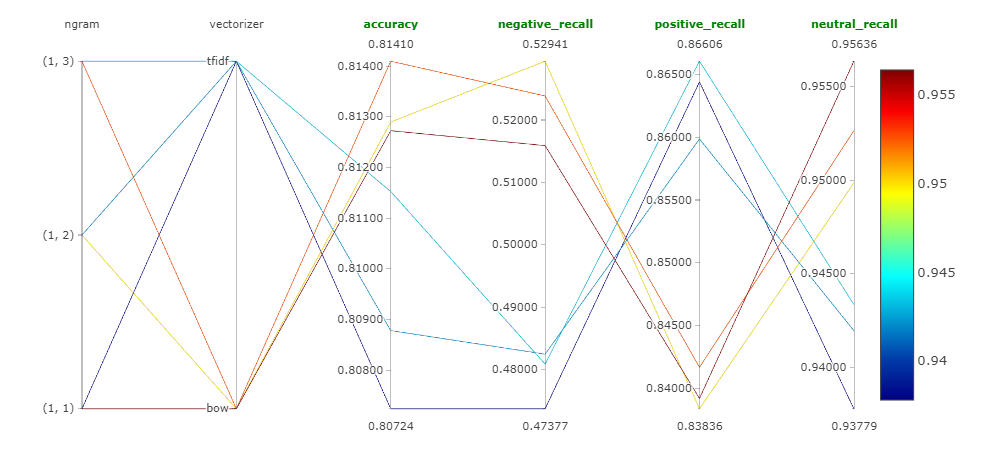

**Experiments suggest that TfIdf with n_gram range of (1,3) works best for the combination of all the 3 classes**